## Autoencoders

In [1]:
# Imports
from vectorization import term_freq_vectorizer

# Main Libraries
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip

# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

# Data Preprocessing and Score Libraries
from sklearn import preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, \
    average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score


# Gradient Boosting
import lightgbm as lgb

# TF and Keras
import tensorflow as tf
import keras
from keras import backend as К
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from keras.layers import BatchNormalization, Input, Lambda
from keras import regularizers
from keras.losses import mse, binary_crossentropy 

In [3]:
# Functions

# Get integers from chirality string
def toInt(chirality_string):
    buff = re.split(r"[();]",chirality_string)
    return [int(buff[1]),int(buff[2])]

# Get the chirality from the list of chirality strings
def getChirality(chirality_list):
    return np.array([toInt(i) for i in chirality_list])

# Anomaly Scores
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF) - np.array(reducedDF))**2, \
                 axis=1)
    loss = pd.Series(data=loss, index=originalDF.index)
    loss = (loss - np.min(loss)) / (np.max(loss) - np.min(loss))
    return loss

# Plot Results
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabels', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabels'], \
                                preds['anomalyScore'])
    average_precision = average_precision_score(preds['trueLabels'], \
        preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, \
                        color='k')
    plt.xlabel('Полнота')
    plt.ylabel('Точность')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Kpивaя "точность - полнота": средняя точность \
                {0:0.2f}' .format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabels'], \
                                     preds['anomalyScore'])
    
    areaUnderROC = auc(fpr,tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC кривая')
    plt.plot([0, 1], [0, 1], color = 'k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Доля ложноположительных исходов')
    plt.ylabel('Доля истинноположительных исходов')
    plt.title('     Рабочая характеристика приемника: \n \
                Площадь под кривой ROC = {0:0.2f}' .format(areaUnderROC))
    plt.legend(loc='lower right')
    plt.show()

    if returnPreds == True:
        return preds


In [24]:
# Data Import and TFidf
os.chdir("C:/Users/User/Desktop/DNA_CNT/")
current_path = os.getcwd()
print(current_path)
file  = os.path.sep.join(['', 'data', \
                                'training_set.csv'])


data = pd.read_csv(current_path + file)


# Change 'N' and 'Y' to 0 and 1
data['Label'] = data['Label'].apply(lambda x: 1 if x == 'Y' else 0)
# Preprocess the data
# Chirality
chirality = getChirality(data['Chirality'])
chirality = pd.DataFrame(chirality, columns=['m','n'])


# Transform
dataX = term_freq_vectorizer.transform(data['Sequence'])
dataX = pd.DataFrame(dataX.toarray(), columns=term_freq_vectorizer.get_feature_names_out())

dataY = data['Label']

""" # PCA
featuresToScale = dataX.columns
sX = pre.StandardScaler(copy=True, with_mean=True,
                                   with_std=True)
dataX.loc[:, featuresToScale] = \
            sX.fit_transform(dataX[featuresToScale])
"""
# Merge the dataframes
dataX = pd.concat([dataX,chirality],axis=1)

# Split the data
X_train, X_test, y_train, y_test = \
    train_test_split(dataX, dataY, test_size = 0.33, \
                    random_state = 2021, stratify=dataY)

X_train_AE = X_train.copy()
X_test_AE = X_test.copy()

dataX.head()

C:\Users\User\Desktop\DNA_CNT


,c,cc,ccc,cct,ct,ctc,ctt,t,tc,tcc,tct,tt,ttc,ttt,m,n
0,0.371174,0.085089,0.0,0.09028,0.31172,0.371297,0.0,0.519644,0.302763,0.088509,0.418401,0.195654,0.099841,0.137737,10,2
1,0.371174,0.085089,0.0,0.09028,0.31172,0.371297,0.0,0.519644,0.302763,0.088509,0.418401,0.195654,0.099841,0.137737,10,3
2,0.371174,0.085089,0.0,0.09028,0.31172,0.371297,0.0,0.519644,0.302763,0.088509,0.418401,0.195654,0.099841,0.137737,11,1
3,0.371174,0.085089,0.0,0.09028,0.31172,0.371297,0.0,0.519644,0.302763,0.088509,0.418401,0.195654,0.099841,0.137737,8,5
4,0.371174,0.085089,0.0,0.09028,0.31172,0.371297,0.0,0.519644,0.302763,0.088509,0.418401,0.195654,0.099841,0.137737,9,6


### Model No.1 - 2-layer autoencoder with Linear activation

Epoch 1/10
651/651 [==============================] - 1s 961us/step - loss: 0.8778 - accuracy: 0.9555 - val_loss: 0.0425 - val_accuracy: 1.0000
Epoch 2/10
651/651 [==============================] - 1s 794us/step - loss: 0.0237 - accuracy: 0.9447 - val_loss: 0.0168 - val_accuracy: 0.8786
Epoch 3/10
651/651 [==============================] - 0s 760us/step - loss: 0.0134 - accuracy: 0.9048 - val_loss: 0.0094 - val_accuracy: 0.8771
Epoch 4/10
651/651 [==============================] - 1s 802us/step - loss: 0.0076 - accuracy: 0.8986 - val_loss: 0.0055 - val_accuracy: 0.8848
Epoch 5/10
651/651 [==============================] - 1s 776us/step - loss: 0.0047 - accuracy: 0.9002 - val_loss: 0.0038 - val_accuracy: 0.9293
Epoch 6/10
651/651 [==============================] - 1s 783us/step - loss: 0.0031 - accuracy: 0.8894 - val_loss: 0.0022 - val_accuracy: 0.8940
Epoch 7/10
651/651 [==============================] - 0s 763us/step - loss: 0.0023 - accuracy: 0.8909 - val_loss: 0.0023 - val_accuracy:

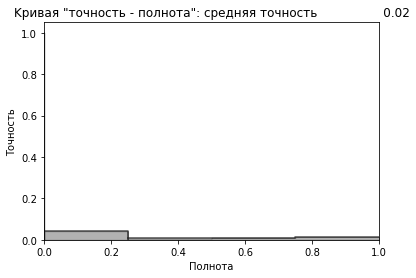

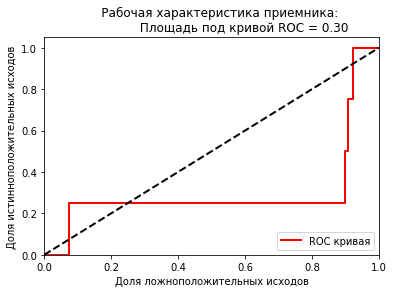

In [26]:
# Keras API call
model = Sequential()

# Layers
model.add(Dense(units=16, activation='linear', input_dim=16))
model.add(Dense(units=16, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', \
                metrics=['accuracy'])

num_epochs = 10
batch_size = 1

history = model.fit( x= X_train_AE, y = X_train_AE, epochs=num_epochs, \
    batch_size=batch_size, shuffle=True, \
    validation_data=(X_train_AE, X_train_AE), verbose=1)

predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds, avgPrecision = plotResults(y_test, anomalyScoresAE, True)

### Model No.2 - 2-Layer incomplete autoencode with linear activation

Epoch 1/10
651/651 [==============================] - 1s 1ms/step - loss: 1.0861 - accuracy: 0.9278 - val_loss: 0.0345 - val_accuracy: 0.9539
Epoch 2/10
651/651 [==============================] - 1s 853us/step - loss: 0.0289 - accuracy: 0.9063 - val_loss: 0.0256 - val_accuracy: 0.8879
Epoch 3/10
651/651 [==============================] - 1s 891us/step - loss: 0.0212 - accuracy: 0.8940 - val_loss: 0.0182 - val_accuracy: 0.8940
Epoch 4/10
651/651 [==============================] - 1s 854us/step - loss: 0.0164 - accuracy: 0.8971 - val_loss: 0.0140 - val_accuracy: 0.8587
Epoch 5/10
651/651 [==============================] - 1s 846us/step - loss: 0.0127 - accuracy: 0.8848 - val_loss: 0.0121 - val_accuracy: 0.9140
Epoch 6/10
651/651 [==============================] - 1s 839us/step - loss: 0.0093 - accuracy: 0.9048 - val_loss: 0.0072 - val_accuracy: 0.8633
Epoch 7/10
651/651 [==============================] - 1s 855us/step - loss: 0.0066 - accuracy: 0.9002 - val_loss: 0.0048 - val_accuracy: 0

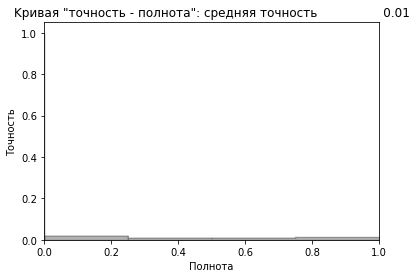

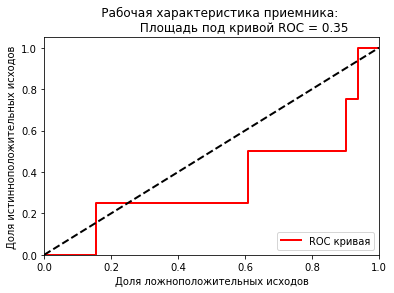

In [ ]:
model = Sequential()

# Layers
model.add(Dense(units=15, activation='linear', input_dim=16))
model.add(Dense(units=14, activation='linear'))
model.add(Dense(units=16, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', \
                metrics=['accuracy'])

# Train the model
num_epochs = 10
batch_size = 1

history = model.fit( x= X_train, y = X_train, epochs=num_epochs, \
    batch_size=batch_size, shuffle=True, \
    validation_data=(X_train, X_train), verbose=1)

# Evaluate the model
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)

### Model No.3 - Non-linear autoencoder with ReLU activation

Epoch 1/10
651/651 [==============================] - 1s 1ms/step - loss: 5.6117 - accuracy: 0.0000e+00 - val_loss: 5.5220 - val_accuracy: 0.0000e+00
Epoch 2/10
651/651 [==============================] - 1s 923us/step - loss: 4.8216 - accuracy: 0.1275 - val_loss: 0.1177 - val_accuracy: 1.0000
Epoch 3/10
651/651 [==============================] - 1s 901us/step - loss: 0.0486 - accuracy: 0.9432 - val_loss: 0.0426 - val_accuracy: 0.9631
Epoch 4/10
651/651 [==============================] - 1s 912us/step - loss: 0.0421 - accuracy: 0.9278 - val_loss: 0.0411 - val_accuracy: 0.9201
Epoch 5/10
651/651 [==============================] - 1s 915us/step - loss: 0.0414 - accuracy: 0.9386 - val_loss: 0.0409 - val_accuracy: 0.8833
Epoch 6/10
651/651 [==============================] - 1s 901us/step - loss: 0.0407 - accuracy: 0.9309 - val_loss: 0.0413 - val_accuracy: 0.8571
Epoch 7/10
651/651 [==============================] - 1s 925us/step - loss: 0.0401 - accuracy: 0.9324 - val_loss: 0.0397 - val_acc

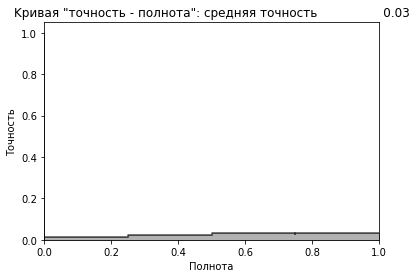

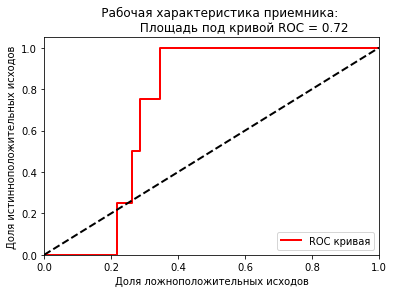

In [28]:
model = Sequential()

# Layers
model.add(Dense(units=15, activation='relu', input_dim=16))
model.add(Dense(units=14, activation='relu'))
model.add(Dense(units=15, activation='relu'))
model.add(Dense(units=16, activation='relu'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', \
                metrics=['accuracy'])

# Train the model
num_epochs = 10
batch_size = 1

history = model.fit( x= X_train, y = X_train, epochs=num_epochs, \
    batch_size=batch_size, shuffle=True, \
    validation_data=(X_train, X_train), verbose=1)

# Evaluate the model
predictions = model.predict(X_test, verbose=1)
anomalyScoresAE = anomalyScores(X_test, predictions)
preds = plotResults(y_test, anomalyScoresAE, True)